In [1]:
import numpy as np
import pandas as pd
from numpy import dtype
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn
from scipy import stats,signal
from datetime import date
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from eofs.standard import Eof

# Question 1

In [2]:
lon1=0;lon2=360
lat1=-75;lat2=75
iyr1=1979
iyr2=2020

#read nino3.4 data from a CSV (comma-separated) file into DataFrame
nino34=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/detrend.nino34.ascii.txt", sep="\s+")
yr=nino34.YR
mon=nino34.MON
anom=nino34.TOTAL

#find indices of Dec in 1979-2020
D0=np.where((mon == 12) & (yr >= iyr1) & (yr <= iyr2))[0] # dec(0)
nyr=len(D0) 

#calculate DJF mean
DJF0=np.zeros(nyr)
for i in range(nyr):
    DJF0[i]=np.mean(anom[D0[i]:D0[i]+3])    

#stanrard deviation and selection
std=np.std(DJF0)
xm=np.mean(DJF0)
#Normalize the time series and save in a new array "DJF"
DJF=np.zeros(nyr)
DJF=(DJF0-xm)/std

pos=np.where(DJF >=  1.0)[0]
neg=np.where(DJF <= -1.0)[0]

#pos and neg DJF that pass test
yr_pos=yr[D0[pos]]
print("Positive:")
print(yr_pos)
yr_neg=yr[D0[neg]]
print("Negative:")
print(yr_neg)

Positive:
395    1982
443    1986
503    1991
575    1997
719    2009
791    2015
Name: YR, dtype: int64
Negative:
467    1988
587    1998
599    1999
695    2007
731    2010
Name: YR, dtype: int64


/data/keeling/a/junrenw2/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Text(0.5, 1.0, 'Composite differences of H500 in the DJF')

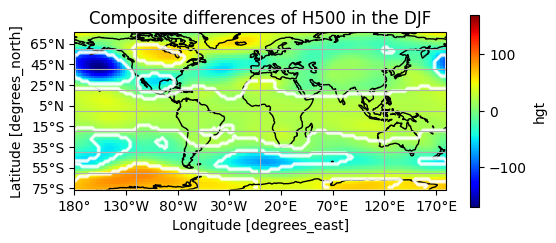

In [3]:
## Load H500 data and calculate monthly anomalies
hgt_path = '/data/zhuowang/b/shared/NNR2/monthly/hgt.mon.mean.nc'
hgt_data = xr.open_dataset(hgt_path)['hgt'].sel(level = 500, lat=slice(lat1, lat2, -1), lon=slice(lon1, lon2))
hgt_mean_of_seasons = hgt_data.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF']
hgt_elnino = hgt_mean_of_seasons.sel(time=hgt_mean_of_seasons.time.dt.year.isin([yr_pos]))
hgt_lanino =  hgt_mean_of_seasons.sel(time=hgt_mean_of_seasons.time.dt.year.isin([yr_neg]))
hgt_elnino_composite_mean = hgt_elnino.mean('time')
hgt_lanino_composite_mean = hgt_lanino.mean('time')
hgt_elnino_lanino_composite_mean_difference = hgt_elnino_composite_mean-hgt_lanino_composite_mean

fig, ax = plt.subplots(1, figsize=(6, 2.5), subplot_kw={'projection': ccrs.PlateCarree()})
hgt_elnino_lanino_composite_mean_difference.plot(ax = ax, cmap='jet')


# Perform the t-test
t_stat, p_value = ttest_ind(hgt_elnino, hgt_lanino, equal_var=True)
spy1 = np.where(p_value < 0.05, 1, 0)
sig = xr.DataArray(data=spy1, dims=["lat", "lon"], coords=[hgt_elnino_lanino_composite_mean_difference.lat,hgt_elnino_lanino_composite_mean_difference.lon] )
sig.plot.contour(ax = ax,colors = 'white', alpha = 0.5)

ax.coastlines()
ax.gridlines()
xticks = range(-180, 180, 50)
yticks = range(-75, 75, 20)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# set the latitude and longitude tick labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax.set_title("Composite differences of H500 in the DJF")

# Question 2

/data/keeling/a/junrenw2/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Text(0.5, 1.0, 'Composite differences of H500 in the MAM')

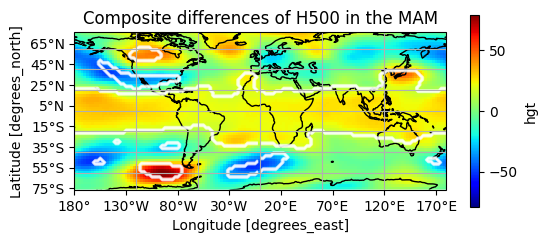

In [4]:
## Load H500 data and 
hgt_path = '/data/zhuowang/b/shared/NNR2/monthly/hgt.mon.mean.nc'
hgt_data = xr.open_dataset(hgt_path)['hgt'].sel(level = 500, lat=slice(lat1, lat2, -1), lon=slice(lon1, lon2))
hgt_mean_of_seasons = hgt_data.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['MAM']
hgt_elnino = hgt_mean_of_seasons.sel(time=hgt_mean_of_seasons.time.dt.year.isin([yr_pos+1]))
hgt_lanino =  hgt_mean_of_seasons.sel(time=hgt_mean_of_seasons.time.dt.year.isin([yr_neg+1]))
hgt_elnino_composite_mean = hgt_elnino.mean('time')
hgt_lanino_composite_mean = hgt_lanino.mean('time')
hgt_elnino_lanino_composite_mean_difference = hgt_elnino_composite_mean-hgt_lanino_composite_mean

fig, ax = plt.subplots(1, figsize=(6, 2.5), subplot_kw={'projection': ccrs.PlateCarree()})
hgt_elnino_lanino_composite_mean_difference.plot(ax = ax, cmap='jet')


# Perform the t-test
t_stat, p_value = ttest_ind(hgt_elnino, hgt_lanino, equal_var=True)
spy1 = np.where(p_value < 0.05, 1, 0)
sig = xr.DataArray(data=spy1, dims=["lat", "lon"], coords=[hgt_elnino_lanino_composite_mean_difference.lat,hgt_elnino_lanino_composite_mean_difference.lon])
sig.plot.contour(ax = ax,colors = 'white', alpha = 0.5)

ax.coastlines()
ax.gridlines()
xticks = range(-180, 180, 50)
yticks = range(-75, 75, 20)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# set the latitude and longitude tick labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax.set_title("Composite differences of H500 in the MAM")

# Question 3


In [5]:
# Calculate the seasonal mean Nino3.4 during 1979-2019 SON 
lon1=0;lon2=360
lat1=-75;lat2=75
iyr1=1979
iyr2=2019

#read nino3.4 data from a CSV (comma-separated) file into DataFrame
nino34=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/detrend.nino34.ascii.txt", sep="\s+")
yr=nino34.YR
mon=nino34.MON
anom=nino34.TOTAL

#find indices of Dec in 1979-2020
S0=np.where((mon == 9) & (yr >= iyr1) & (yr <= iyr2))[0] # dec(0)
nyr=len(S0) 

#calculate SON mean
SON0=np.zeros(nyr)
for i in range(nyr):
    SON0[i]=np.mean(anom[S0[i]:S0[i]+3])    
df = pd.DataFrame(data = {"year": np.arange(iyr1, iyr2+1),"nino34_SON": SON0})

# Calculate the seasonal mean precipitation anomalies during 1979-2019 DJF 
precip_path = '/data/zhuowang/b/shared/CMAP/precip.mon.mean.nc'
precip_data = xr.open_dataset(precip_path)['precip']
precip_data = precip_data.sel(lat=slice(lat1, lat2,-1), lon=slice(lon1, lon2), time = slice("1980", "2019"))
precip_data = precip_data.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF']
precip_clim = precip_data.mean(dim='time')
precip_anom = precip_data - precip_clim

# a simple linear regression model 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

def linear_regression_predict( precip_vals):
    # Create a linear regression object
    lr = LinearRegression()

    # Create empty arrays for the predicted and observed precipitation
    y_pred = []
    y_obs = []

    # Perform leave-one-out cross validation
    for i in range(len(precip_vals.values)):
        # Split the data into training and testing sets
        X_train = np.delete(SON0, i).reshape(-1, 1)
        y_train = np.delete(precip_vals.values, i).reshape(-1, 1)
        X_test = np.array(SON0[i]).reshape(1, -1)

        # Fit the linear regression model
        lr.fit(X_train, y_train)

        # Predict the precipitation for the test year
        y_pred.append(lr.predict(X_test)[0][0])
        y_obs.append(precip_vals.values[i])

    # Calculate the ACC between the predicted and observed precipitation
    c = np.mean(y_obs)
    acc = np.mean((y_obs-c)*(y_pred-c)) / np.sqrt(np.mean((y_pred-c)**2)*np.mean((y_obs-c)**2))

    # Return the predicted precipitation time series and the ACC
    return xr.DataArray(y_pred, coords=[precip_vals.coords['time']], dims=['time']), acc

# Create empty arrays for the predicted precipitation and ACC
precip_pred = np.zeros_like(precip_anom)
acc = np.zeros_like(precip_clim)

# Loop over each grid point
for i in range(len(precip_anom.lat)):
    for j in range(len(precip_anom.lon)):
        # Get the precipitation time series for this grid point
        precip_vals = precip_anom[:, i, j]

        # Skip grid points with missing data
        if np.isnan(precip_vals).any():
            continue

        # Perform linear regression and calculate the ACC
        y_pred, acc[i, j] = linear_regression_predict(precip_vals)

        # Store the predicted precipitation values
        precip_pred[:, i, j] = y_pred

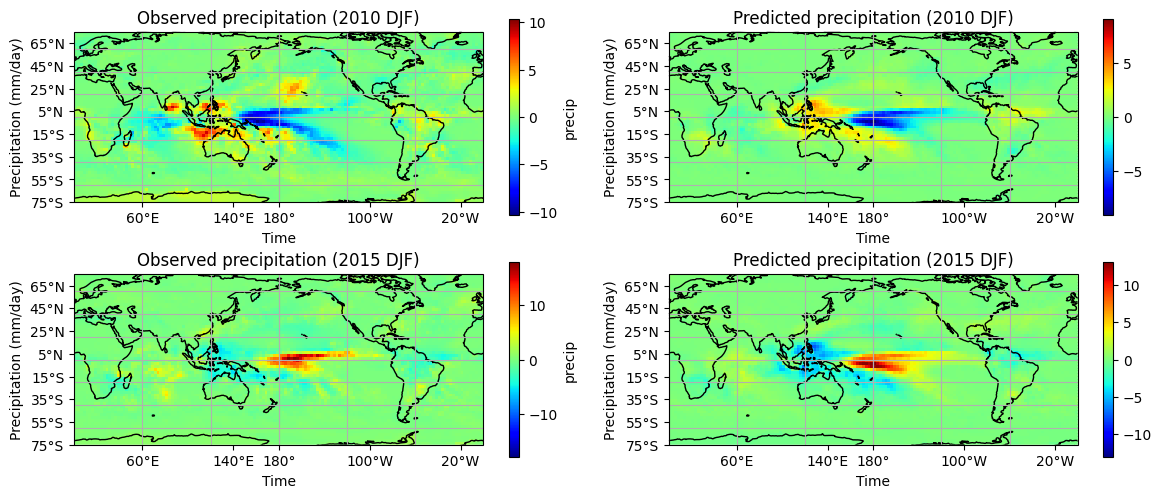

In [6]:
# Plot the observed and predicted precipitation side by side for 2010 DJF (i.e., 2010.12-2011.02) and 2015 DJF (2015.12-2016.02)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot the observed precipitation in the left subplot
precip_anom.sel(time = "2010").plot(ax=axs[0,0], cmap = 'jet', transform = ccrs.PlateCarree())
precip_pred =xr.DataArray(precip_pred, coords={'time': precip_anom.time,'lat': precip_anom.lat, 'lon': precip_anom.lon},
                          dims=['time', 'lat', 'lon']) 
precip_pred.sel(time = "2010").plot(ax=axs[0,1], cmap = 'jet', transform = ccrs.PlateCarree())


year = 2010
# Set the titles and labels
axs[0,0].set_title(f'Observed precipitation ({year} DJF)')
axs[0,1].set_title(f'Predicted precipitation ({year} DJF)')
axs[0,0].set_xlabel('Time')
axs[0,1].set_xlabel('Time')

axs[0,0].set_ylabel('Precipitation (mm/day)')
axs[0,1].set_ylabel('Precipitation (mm/day)')
axs[0,0].coastlines()
axs[0,0].gridlines()
axs[0,1].coastlines()
axs[0,1].gridlines()
xticks = range(-180, 180, 80)
yticks = range(-75, 75, 20)
axs[0,0].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[0,0].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[0,1].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[0,1].set_yticks(yticks, crs=ccrs.PlateCarree())
# set the latitude and longitude tick labels
axs[0,0].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[0,0].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[0,1].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[0,1].yaxis.set_major_formatter(cticker.LatitudeFormatter())

precip_anom.sel(time = "2015").plot(ax=axs[1,0], cmap = 'jet', transform = ccrs.PlateCarree())
precip_pred =xr.DataArray(precip_pred, coords={'time': precip_anom.time,'lat': precip_anom.lat, 'lon': precip_anom.lon},
                          dims=['time', 'lat', 'lon']) 
precip_pred.sel(time = "2015").plot(ax=axs[1,1], cmap = 'jet', transform = ccrs.PlateCarree())


year = 2015
# Set the titles and labels
axs[1,0].set_title(f'Observed precipitation ({year} DJF)')
axs[1,1].set_title(f'Predicted precipitation ({year} DJF)')
axs[1,0].set_xlabel('Time')
axs[1,1].set_xlabel('Time')
axs[1,0].set_ylabel('Precipitation (mm/day)')
axs[1,1].set_ylabel('Precipitation (mm/day)')
axs[1,0].coastlines()
axs[1,0].gridlines()
axs[1,1].coastlines()
axs[1,1].gridlines()
axs[1,0].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[1,0].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[1,1].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[1,1].set_yticks(yticks, crs=ccrs.PlateCarree())
# set the latitude and longitude tick labels
axs[1,0].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[1,0].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[1,1].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[1,1].yaxis.set_major_formatter(cticker.LatitudeFormatter())
plt.tight_layout()

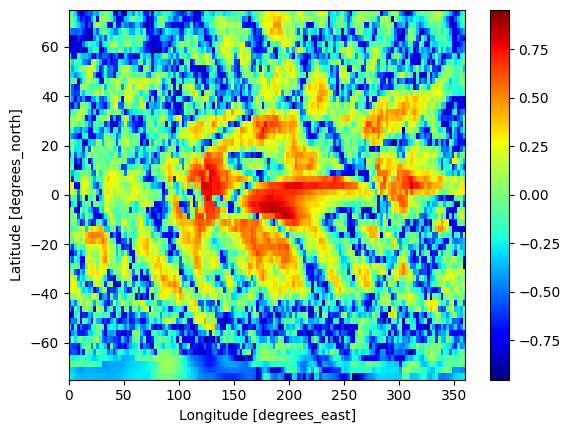

In [7]:
# Plot the map of ACC
acc =xr.DataArray(acc, coords={'lat': precip_anom.lat, 'lon': precip_anom.lon},
                          dims=['lat', 'lon']) 
acc.plot( cmap = 'jet')

# Question 4

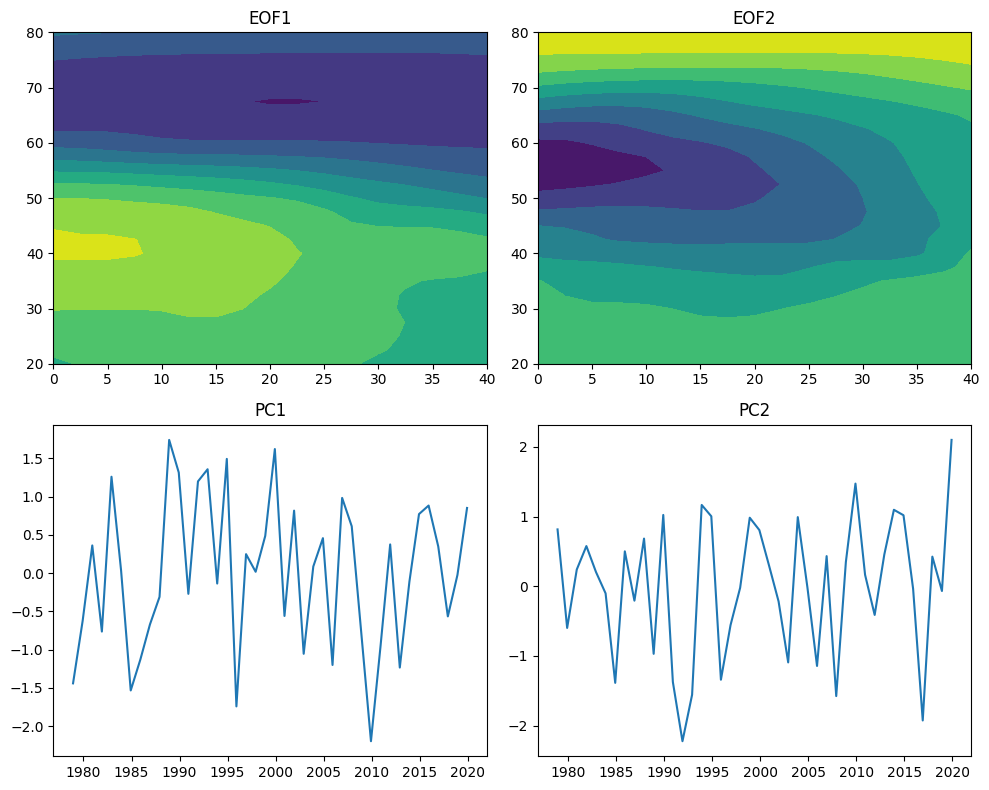

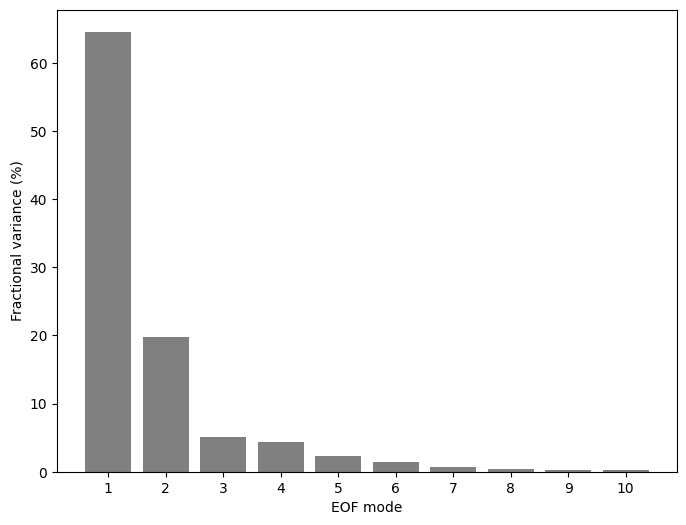

In [8]:
#• Calculate the seasonal mean SLP during December through Feb (DJF) from 1979-2019 
# from the monthly mean data over the Atlantic sector (20-80N, 90W-40E) (Please note 
# that the domain crosses the prime meridian) 

lon1=-90;lon2=40
lat1= 20;lat2=80
iyr1=1979
iyr2=2019

slp_path = '/data/zhuowang/b/shared/NNR2/monthly/mslp.mon.mean.nc'
slp_data = xr.open_dataset(slp_path)['mslp']
slp_data = slp_data.sel(lat=slice(lat1, lat2,-1), lon=slice(lon1, lon2), time = slice("1979", "2019"))
slp_data = slp_data.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF']


#• Extract the first two EOF modes and the corresponding Principal component (PC) time 
# series. Since the grid cell area decreases poleward, please apply the square root of the 
# cosine latitude as a weighting  function. This way the covariance matrix is weighted by 
# the cosine function and the decreasing grid cell area is properly considered. 


weights_array = np.sqrt(np.cos(np.deg2rad(slp_data.lat.values)))[:, np.newaxis]

solver = Eof(slp_data.values, weights=weights_array)
eof1 = solver.eofs(neofs=2)[0]
eof2 = solver.eofs(neofs=2)[1]
pc1 = solver.pcs(npcs=2, pcscaling=1)[:,0] # scaled to unit variance
pc2 =solver.pcs(npcs=2, pcscaling=1)[:,1] # scaled to unit vairnace
# Plot the first two EOF modes and PC time series
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axs[0, 0].contourf(slp_data.lon, slp_data.lat, eof1)
axs[0, 0].set_title('EOF1')
axs[0, 1].contourf(slp_data.lon, slp_data.lat, eof2)
axs[0, 1].set_title('EOF2')
axs[1, 0].plot(slp_data.time, pc1 , label='PC1')
axs[1, 0].set_title('PC1')
axs[1, 1].plot(slp_data.time, pc2, label='PC2')
axs[1, 1].set_title('PC2')
plt.tight_layout()
plt.show() 
# Plot the fractional variance of the first 10 EOF modes
variance = solver.varianceFraction()
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(10) + 1, variance[:10] * 100, align='center', color='gray')
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1)
ax.set_xlabel('EOF mode')
ax.set_ylabel('Fractional variance (%)')
plt.show()

# Question 5

In [9]:
#define the latlon domain and the time period
lat1=10;lat2=70
lon1=210;lon2=320
lev0=500
iyr1=1979;iyr2=2020
nyr=iyr2-iyr1+1
#dtxx can be used to select a subset of data in the time dimensio
dt01='-12-01';dt02='-12-31'
dt11='-01-01';dt12='-02-28'	#neglect leap years
ndy=(date(1980,2,28)-date(1979,12,1)).days+1

#number of weather regimes
nclusters=4

#input file info
dir='/data/zhuowang/b/zhuowang/Data/NNR2/daily/hgt.'
hgt = xr.DataArray(np.zeros((nyr, ndy,len(np.arange(lat1,lat2+1, 2.5)) , len(np.arange(lon1, lon2+1, 2.5)))), dims=('year', 'day', 'lat', 'lon'),
                   coords={'year': np.arange(iyr1, iyr2+1), 'day': np.arange(1, ndy+1),
                           'lat': np.arange(lat1,lat2+1, 2.5), 'lon': np.arange(lon1, lon2+1, 2.5)})
"""
Read daily H500 during Dec-Feb from 1979-2020. 
Note that the latitude dimension is reversed!
"""
for iyr in range(iyr1,iyr2+1):
   #read Dec in Year(0) into hgt0
    df = xr.open_dataset(dir+str(iyr)+'.nc')
    hgt0 = df['hgt'].sel(level=500, time=slice(str(iyr)+dt01,str(iyr)+dt02), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
    #read Jan and Feb in Year(+1) into hgt1
    df = xr.open_dataset(dir+str(iyr+1)+'.nc')
    hgt1 = df['hgt'].sel(level=500, time=slice(str(iyr+1)+dt11,str(iyr+1)+dt12), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
   #concatenate Dec data and Jan-Feb data. hgt01 is of the shape [nyr, ndy, nlat, nlon]
    hgt01=xr.concat([hgt0,hgt1],dim='time') 
    #take the 5-day running mean using "rolling" and save the output in the array hgt
    #hgt is of the shape [nyr, ndy, nlat, nlon]
    hgt[iyr-iyr1,:,:,:]=hgt01.rolling(time=5, center=True,min_periods=3).mean().values
print('Finish reading H500')


#remove the seasonal cycle (the long-term mean on each calendar day) 
hgt = hgt-hgt.groupby('day').mean(dim='year')


#remove the linear trend
# compute the linear trend for each grid point time series
trend = hgt.polyfit(dim='year', deg=1)

# subtract the linear trend from the data

hgt = hgt - trend.polyfit_coefficients.sel(degree=1)*hgt['year']-trend.polyfit_coefficients.sel(degree=0)


Finish reading H500


/data/keeling/a/junrenw2/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


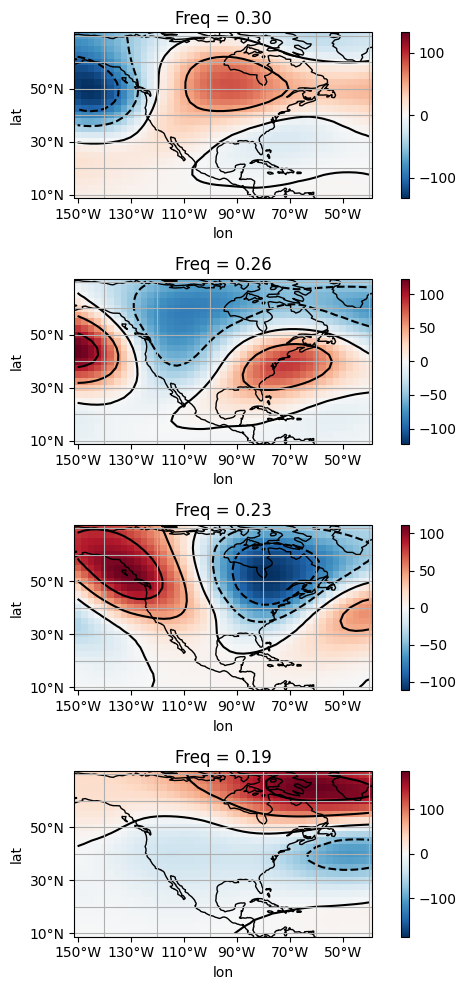

In [10]:
weights_array = np.sqrt(np.cos(np.deg2rad(hgt.lat.values)))[:, np.newaxis]
hgt_stacked = hgt.stack(time=['year', 'day']).transpose('time', 'lat', 'lon')
solver = Eof(hgt_stacked.values, weights=weights_array)
pcs = solver.pcs(npcs=3, pcscaling=1)
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(pcs)
labels = xr.DataArray(labels, dims=['time'], coords={'time': hgt_stacked.time})

freq = labels.groupby(labels).count(dim='time') / len(labels)
inx = np.argsort(-freq.values)

fig, axs = plt.subplots(4, figsize=(6, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_n = 0
for i in inx:
    composite = hgt_stacked.sel(time=labels==i).mean(dim='time')
    # plot the composite mean using matplotlib or other plotting libraries
#     composite.plot(ax = axs[plot_n],vmin = -150, vmax = 200 , cmap = 'RdBu')
    composite.plot(ax = axs[plot_n])
    composite.plot.contour(ax = axs[plot_n], colors='black')
    axs[plot_n].set_title("Freq = "+ str(freq.values[i])[:4])
    axs[plot_n].coastlines()
    axs[plot_n].gridlines()
    xticks = range(-150, -40, 20)
    yticks = range(10, 70, 20)
    axs[plot_n].set_xticks(xticks, crs=ccrs.PlateCarree())
    axs[plot_n].set_yticks(yticks, crs=ccrs.PlateCarree())
    # set the latitude and longitude tick labels
    axs[plot_n].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    axs[plot_n].yaxis.set_major_formatter(cticker.LatitudeFormatter())
    plot_n = plot_n+1
# add tight layout to the figure
plt.tight_layout()
plt.show()